# Prepocessing dataset for the multilabel text classification

I use arXiv dataset for the multilabel text classification problem.
The raw metadata `arxiv-metadata-oai-snapshot-2020-08-14.json` downloaded from [here](https://www.kaggle.com/Cornell-University/arxiv/version/6?select=arxiv-metadata-oai-snapshot-2020-08-14.json).

The json file contains metadata from ~1.7 million articles. 

To preprocess the json file I used a high-RAM instance (~25Gb) of the jupyter notebook.

In [1]:
import os
import pandas as pd
import numpy as np
import json

In [2]:
data_dir = "/content/drive/MyDrive/Notebooks_BERT/data"
meta_df = pd.read_json(os.path.join(data_dir,"input","arxiv-metadata-oai-snapshot-2020-08-14.json"), lines=True)

In [3]:
# Make sure that the data loaded
meta_df.shape

(1747307, 14)

In [4]:
meta_df.head(3)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"


In [6]:
# For the multilabel classification we use title, categories and abstract
columns = ['title', 'abstract', 'categories']
meta_dfs = meta_df[columns]

In [ ]:
# Make a list of categories in the new column
meta_dfs['category'] = meta_dfs.categories.str.split(' ')
# Define main category(ies) for each article by removing subcategories 
# defined after the dot
meta_dfs['main_category'] = meta_dfs.category.apply(lambda x:[a.split('.')[0] for a in x])
meta_dfs.drop(columns=['categories','category'], inplace=True)

In [8]:
meta_dfs.head(3)

,title,abstract,main_category
0,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,[hep-ph]
1,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...","[math, cs]"
2,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,[physics]


In [9]:
# encode categories into labele columns
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(meta_dfs.main_category)
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [10]:
# We successfully generated a category encoding for every article
len(labels)

1747307

In [11]:
# There are in total 38 categories
labels[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [13]:
df = pd.concat([meta_dfs[['abstract','title']], pd.DataFrame(labels)], axis=1)
df.columns = ['abstract','title'] + list(mlb.classes_)
df.head(4)

,abstract,title,acc-phys,adap-org,alg-geom,ao-sci,astro-ph,atom-ph,bayes-an,chao-dyn,chem-ph,cmp-lg,comp-gas,cond-mat,cs,dg-ga,econ,eess,funct-an,gr-qc,hep-ex,hep-lat,hep-ph,hep-th,math,math-ph,mtrl-th,nlin,nucl-ex,nucl-th,patt-sol,physics,plasm-ph,q-alg,q-bio,q-fin,quant-ph,solv-int,stat,supr-con
0,A fully differential calculation in perturba...,Calculation of prompt diphoton production cros...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"We describe a new algorithm, the $(k,\ell)$-...",Sparsity-certifying Graph Decompositions,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,The evolution of Earth-Moon system is descri...,The evolution of the Earth-Moon system based o...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,We show that a determinant of Stirling cycle...,A determinant of Stirling cycle numbers counts...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
# For our task we remove the categories with small number of articles
columns = df.columns
# Find the frequencies of the articles in every category
categor_freq = df[columns[2:]].sum()/df.shape[0]
categor_freq

acc-phys    0.000028
adap-org    0.000334
alg-geom    0.000814
ao-sci      0.000010
astro-ph    0.157579
atom-ph     0.000070
bayes-an    0.000009
chao-dyn    0.001372
chem-ph     0.000144
cmp-lg      0.000512
comp-gas    0.000126
cond-mat    0.167866
cs          0.167716
dg-ga       0.000419
econ        0.001527
eess        0.013718
funct-an    0.000244
gr-qc       0.047656
hep-ex      0.024107
hep-lat     0.013517
hep-ph      0.086720
hep-th      0.079263
math        0.267157
math-ph     0.035722
mtrl-th     0.000150
nlin        0.019965
nucl-ex     0.011834
nucl-th     0.027325
patt-sol    0.000372
physics     0.099816
plasm-ph    0.000022
q-alg       0.000903
q-bio       0.018343
q-fin       0.006655
quant-ph    0.060509
solv-int    0.000809
stat        0.044320
supr-con    0.000100
dtype: float64

In [15]:
import matplotlib.pyplot as plt

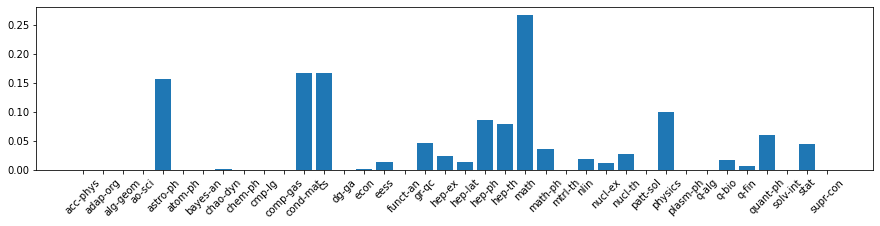

In [16]:
plt.rcParams["figure.figsize"] = (15,3)
plt.bar(categor_freq.index, categor_freq.values)
_ = plt.xticks(rotation = 45)

In [17]:
# Drop the categories with low frequencies
signif_cols = categor_freq.index[categor_freq.values>0.05]
df0 = df[['abstract', 'title']+list(signif_cols)]
# Remove articles with zeros in all the categories
df0 = df0.loc[df0[signif_cols].sum(axis=1)>0]
df0.head(4)

,abstract,title,astro-ph,cond-mat,cs,hep-ph,hep-th,math,physics,quant-ph
0,A fully differential calculation in perturba...,Calculation of prompt diphoton production cros...,0,0,0,1,0,0,0,0
1,"We describe a new algorithm, the $(k,\ell)$-...",Sparsity-certifying Graph Decompositions,0,0,1,0,0,1,0,0
2,The evolution of Earth-Moon system is descri...,The evolution of the Earth-Moon system based o...,0,0,0,0,0,0,1,0
3,We show that a determinant of Stirling cycle...,A determinant of Stirling cycle numbers counts...,0,0,0,0,0,1,0,0


In [ ]:
df0.shape

(1614347, 10)

In [ ]:
# Save the preprocessed data
df0.to_csv(os.path.join(data_dir,"input","arxiv-preproc-data.tsv"), sep="\t", header=True, index=False)

# Data exploration step: plot abstracts using PCA

Let's make sure that the data makes sense

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
# To reduce the data size we randomly subsample abstracts with a single category
sample_pca = df0.loc[df0.iloc[:,2:].apply(sum, axis=1) == 1,:].sample(n = 10_000, random_state = 4)

In [85]:
sample_pca.head()

,abstract,title,astro-ph,cond-mat,cs,hep-ph,hep-th,math,physics,quant-ph
61573,Let $\Gamma$ be a group and $r_n(\Gamma)$ th...,Representation Growth of Linear Groups,0,0,0,0,0,1,0,0
1386987,In these lecture notes I briefly discuss the...,The Zoo of Neutron Stars,1,0,0,0,0,0,0,0
176438,"According to thermodynamics, the specific he...",Can one measure negative specific heat in the ...,0,1,0,0,0,0,0,0
1442305,We have observed the formation of ripples in...,Ion beam sputtering induced ripple formation i...,0,1,0,0,0,0,0,0
227470,The problem of determining total distance as...,Evaluating cumulative ascent: Mountain biking ...,0,0,0,0,0,0,1,0


In [86]:
X = TfidfVectorizer(stop_words=stop_words).fit_transform(sample_pca.abstract).todense()

In [87]:
pca = PCA(n_components=2).fit(X)
data2D = pd.DataFrame(pca.transform(X), columns = ['PC1','PC2'])

In [88]:
data2D

,PC1,PC2
0,-0.078254,-0.001821
1,0.091926,-0.074583
2,-0.005965,0.037514
3,0.046398,0.006616
4,-0.014078,-0.043016
...,...,...
9995,0.020810,0.010343
9996,0.008519,-0.052235
9997,0.026023,0.081521
9998,-0.053596,-0.032091


In [89]:
# Get the corresponding categories for abstracts
color = sample_pca.iloc[:,2:].apply(lambda x: x.index[x>0][0], axis = 1)
data2D['category'] = color.to_list()

In [90]:
data2D

,PC1,PC2,category
0,-0.078254,-0.001821,math
1,0.091926,-0.074583,astro-ph
2,-0.005965,0.037514,cond-mat
3,0.046398,0.006616,cond-mat
4,-0.014078,-0.043016,physics
...,...,...,...
9995,0.020810,0.010343,hep-ph
9996,0.008519,-0.052235,astro-ph
9997,0.026023,0.081521,hep-ph
9998,-0.053596,-0.032091,math


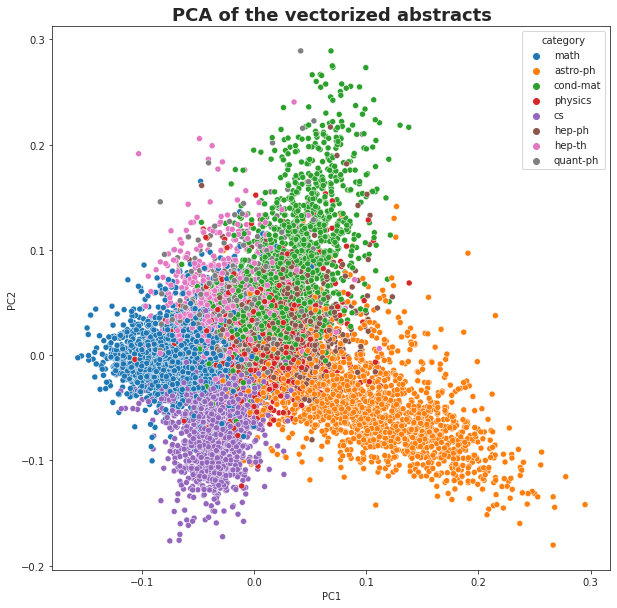

In [91]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10)
sns.set_style("ticks")
_=sns.scatterplot(data=data2D, x='PC1', y='PC2', hue='category')\
                    .set_title("PCA of the vectorized abstracts", fontdict= { 'fontsize': 18, 'fontweight':'bold'})